# Transient Simulation: Loss of one circuit of the line

In [2]:
; cd ..

/Users/rhenriquez/Github_Projects/InverterDynamicLinesModels


In [3]:
] activate

 Activating environment at `~/Github_Projects/InverterDynamicLinesModels/Project.toml`


In [4]:
] instantiate

In [5]:
using OrdinaryDiffEq #Gets the solvers
using Plots
include(joinpath(pwd(), "InverterDynamicLinesModels", "InverterDynamicLinesModels.jl"))

In [6]:
using PowerSystems

In [7]:
# Load Data with PF solution from file
omib_sys = System(joinpath(pwd(), "data", "OMIB_inverter.json"));

┌ Info: Loaded time series from storage file existing=OMIB_inverter_time_series_storage.h5 new=/var/folders/fz/6cnhcl5n2dggz6f6c_l54g740000gn/T/jl_VUUuC0
└ @ InfrastructureSystems /Users/rhenriquez/.julia/packages/InfrastructureSystems/uydla/src/hdf5_time_series_storage.jl:72
┌ Warning: There are no Generator Components in the System
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/Ihfxp/src/utils/IO/system_checks.jl:56
┌ Warning: There are no ElectricLoad Components in the System
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/Ihfxp/src/utils/IO/system_checks.jl:56


## Transient Simulation

### Dynamic Lines

In [8]:
tspan = (0.0, 0.5)
model = get_ode_system(VInertia, DynamicLines)
#Solve Steady State
steady_state = instantiate_model(VInertia, DynamicLines, omib_sys; solve_powerflow = true)
initial_conditions = Array{Pair}(undef, length(steady_state.u0))
parameters_ = Array{Pair}(undef, length(steady_state.parameters))
for (ix, val) in enumerate(steady_state.u0)
    initial_conditions[ix] = MTK.states(model)[ix] => val
end
#Modify the parameters of the line and M
for (ix, val) in enumerate(steady_state.parameters)
    if ix >= 4 && ix <= 5
        print(val)
        print('\n')
        parameters_[ix] = MTK.parameters(model)[ix] => val * 2
    elseif ix >= 6 && ix <= 7
        print(val)
        print('\n')
        parameters_[ix] = MTK.parameters(model)[ix] => val / 2
    elseif ix == 19
        parameters_[ix] = MTK.parameters(model)[ix] => val * 10 #(slow-down M)
    else
        parameters_[ix] = MTK.parameters(model)[ix] => val
    end 
end

#Construct problem
problem = DiffEqBase.ODEProblem(
    model,
    initial_conditions,
    tspan,
    parameters_,
    # Don't use jac = true https://github.com/SciML/ModelingToolkit.jl/issues/390
    jac = false,
)
sol = DiffEqBase.solve(problem, GRK4T(), dtmax = 0.0001);

┌ Info: Results of Nonlinear Solver Algorithm
│  * Algorithm: Trust-region with dogleg and autoscaling
│  * Starting Point: [-0.0137051, -0.0458219, 1.0355794, 0.007016]
│  * Zero: [-0.01370510839707314, -0.04582194530278154, 1.0355794119035249, 0.007016025141344881]
│  * Inf-norm of residuals: 0.000000
│  * Iterations: 1
│  * Convergence: true
│    * |x - x'| < 0.0e+00: false
│    * |f(x)| < 1.0e-08: true
│  * Function Calls (f): 2
│  * Jacobian Calls (df/dx): 2
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/Ihfxp/src/utils/power_flow/power_flow.jl:145
┌ Info: PowerFlow solve converged, the results have been stored in the system
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/Ihfxp/src/utils/power_flow/power_flow.jl:148


0.04599972957574926
0.004700015335324309
0.17857076080070755
2.5129972421186454e-5


In [9]:
#Save v0 magnitude
v1r_ix = 7
v1i_ix = 8
t_long = sol.t
v1r = [value[v1r_ix] for value in sol.u];
v1i = [value[v1i_ix] for value in sol.u];
v1_long = sqrt.( v1r.^2 .+ v1i.^2);

### Algebraic Lines

In [11]:
tspan = (0.0, 0.5)
model = get_ode_system(VInertia, StaticLines)
steady_state = instantiate_model(VInertia, StaticLines, omib_sys; solve_powerflow = true)
initial_conditions = Array{Pair}(undef, length(steady_state.u0))
parameters_ = Array{Pair}(undef, length(steady_state.parameters))
for (ix, val) in enumerate(steady_state.u0)
    initial_conditions[ix] = MTK.states(model)[ix] => val
end
for (ix, val) in enumerate(steady_state.parameters)
    if ix >= 4 && ix <= 5
        print(val)
        print('\n')
        parameters_[ix] = MTK.parameters(model)[ix] => val * 2
    elseif ix >= 6 && ix <= 7
        print(val)
        print('\n')
        parameters_[ix] = MTK.parameters(model)[ix] => val / 2
    elseif ix == 19
        parameters_[ix] = MTK.parameters(model)[ix] => val * 10 #(slow-down M)
    else
        parameters_[ix] = MTK.parameters(model)[ix] => val
    end 
end
problem = DiffEqBase.ODEProblem(
    model,
    initial_conditions,
    tspan,
    parameters_,
    # Don't use jac = true https://github.com/SciML/ModelingToolkit.jl/issues/390
    jac = false,
)
sol = DiffEqBase.solve(problem, GRK4T(), dtmax = 0.0001);

┌ Info: Results of Nonlinear Solver Algorithm
│  * Algorithm: Trust-region with dogleg and autoscaling
│  * Starting Point: [-0.0137051, -0.0458219, 1.0355794, 0.007016]
│  * Zero: [-0.01370510839707314, -0.04582194530278154, 1.0355794119035249, 0.007016025141344881]
│  * Inf-norm of residuals: 0.000000
│  * Iterations: 1
│  * Convergence: true
│    * |x - x'| < 0.0e+00: false
│    * |f(x)| < 1.0e-08: true
│  * Function Calls (f): 2
│  * Jacobian Calls (df/dx): 2
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/Ihfxp/src/utils/power_flow/power_flow.jl:145
┌ Info: PowerFlow solve converged, the results have been stored in the system
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/Ihfxp/src/utils/power_flow/power_flow.jl:148


0.04599972957574926
0.004700015335324309
0.17857076080070755
2.5129972421186454e-5


In [12]:
v1r_ix = 7
v1i_ix = 8
t_static_long = sol.t
v1r = [value[v1r_ix] for value in sol.u];
v1i = [value[v1i_ix] for value in sol.u];
v1_static_long = sqrt.( v1r.^2 .+ v1i.^2);

In [13]:
### AC Static

In [14]:
tspan = (0.0, 0.5)
model = get_ode_system(VInertia, ACStatic)
steady_state = instantiate_model(VInertia, ACStatic, omib_sys; solve_powerflow = true)
initial_conditions = Array{Pair}(undef, length(steady_state.u0))
parameters_ = Array{Pair}(undef, length(steady_state.parameters))
for (ix, val) in enumerate(steady_state.u0)
    initial_conditions[ix] = MTK.states(model)[ix] => val
end
for (ix, val) in enumerate(steady_state.parameters)
    if ix >= 4 && ix <= 5
        print(val)
        print('\n')
        parameters_[ix] = MTK.parameters(model)[ix] => val * 2
    elseif ix >= 6 && ix <= 7
        print(val)
        print('\n')
        parameters_[ix] = MTK.parameters(model)[ix] => val / 2
    else
        parameters_[ix] = MTK.parameters(model)[ix] => val
    elseif ix == 19
        parameters_[ix] = MTK.parameters(model)[ix] => val * 10 #(slow-down M)
    end 
end
problem = DiffEqBase.ODEProblem(
    model,
    initial_conditions,
    tspan,
    parameters_,
    # Don't use jac = true https://github.com/SciML/ModelingToolkit.jl/issues/390
    jac = false,
)
sol = DiffEqBase.solve(problem, GRK4T(), dtmax = 0.0001);

┌ Info: Results of Nonlinear Solver Algorithm
│  * Algorithm: Trust-region with dogleg and autoscaling
│  * Starting Point: [-0.0137051, -0.0458219, 1.0355794, 0.007016]
│  * Zero: [-0.01370510839707314, -0.04582194530278154, 1.0355794119035249, 0.007016025141344881]
│  * Inf-norm of residuals: 0.000000
│  * Iterations: 1
│  * Convergence: true
│    * |x - x'| < 0.0e+00: false
│    * |f(x)| < 1.0e-08: true
│  * Function Calls (f): 2
│  * Jacobian Calls (df/dx): 2
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/Ihfxp/src/utils/power_flow/power_flow.jl:145
┌ Info: PowerFlow solve converged, the results have been stored in the system
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/Ihfxp/src/utils/power_flow/power_flow.jl:148


LoadError: syntax: "if" at none:6 expected "end", got "elseif"

In [16]:
v1r_ix = 7
v1i_ix = 8
t_acstatic_long = sol.t
v1r = [value[v1r_ix] for value in sol.u];
v1i = [value[v1i_ix] for value in sol.u];
v1_acstatic_long = sqrt.( v1r.^2 .+ v1i.^2);

In [17]:
## Attach initial condition to the plots
t_long = vcat([-0.2], t_long)
t_static_long = vcat([-0.2], t_static_long)
t_acstatic_long = vcat([-0.2], t_acstatic_long)
v1_long = vcat([v1_long[1]], v1_long)
v1_static_long = vcat([v1_static_long[1]], v1_static_long)
v1_acstatic_long = vcat([v1_acstatic_long[1]], v1_acstatic_long);

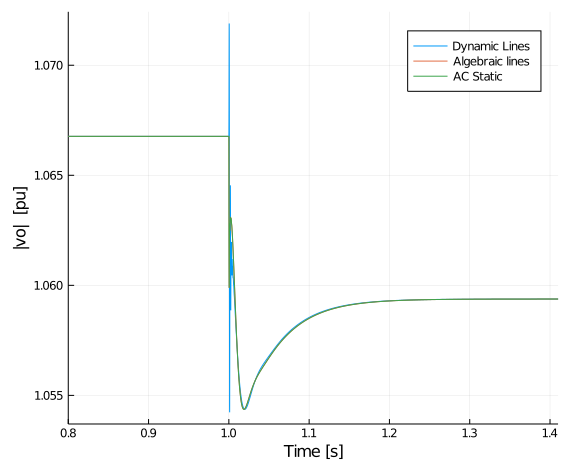

In [23]:
plt = plot(1 .+ t_long, v1_long, label = "Dynamic Lines")
plot!(1 .+ t_static_long, v1_static_long, label = "Algebraic lines")
plot!(1 .+ t_acstatic_long, v1_acstatic_long, label = "AC Static")
plot!(size=(3*190,3*158.1))
plot!(xlims = (0.8, 1.41))
plot!(xlabel="Time [s]")
plot!(ylabel="|vo|  [pu]")
#savefig("long_v1.pdf")
plt

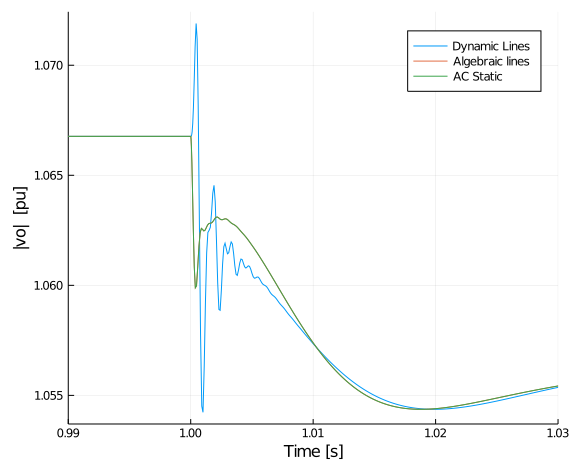

In [24]:
pltz = plot(1 .+ t_long, v1_long, label = "Dynamic Lines")
plot!(1 .+ t_static_long, v1_static_long, label = "Algebraic lines")
plot!(1 .+ t_acstatic_long, v1_acstatic_long, label = "AC Static")
plot!(size=(3*190,3*158.1))
plot!(xlims = (0.99, 1.03))
plot!(xlabel="Time [s]")
plot!(ylabel="|vo|  [pu]")
#savefig("zoom_v1.pdf")
pltz